# *Embeddings*

## O que são *embeddings*?

Os *embeddings* são uma forma de representar palavras como vetores de números reais, no espaço vetorial. Esta representação captura as relações semânticas entre as palavras, permitindo que palavras semelhantes tenham representações semelhantes.

## Porque precisamos de utilizar *embeddings*?
- Permitem analizar o texto utilizando modelos de aprendizagem automática.
- Capturam relações semânticas e relações entre palavras, melhorando a performance dos modelos utilizando em tarefas de processamento de linguagem natural.

## Algumas técnicaas:
### PMI
Mede a associação entre palavras através da comparação da probabilidade conjunta e o produto das probabilidades individuais.
Valores altos representam grande associação entre as palavras.

### Word2Vec
(nunca falámos nas aulas, serve apenas de referência)
Word2Vec é uma técnica baseada em redes neuronais que pode ser utilizada para aprender *embeddings* dado que são treinadas para conseguir compreender o contexto de palavras, dada uma determinada palavra objetivo (Skip-gram) ou prevendo qual é a palavra objetivo dado o contexto (CBOW).

### Autoencoders:
Os autoencoders são redes neuronais que são utilizadas para codificar (*encode*) os dados de input para uma representação de dimensão menor e depois descodificá-la de volta para os dados originais.

### GloVe (Global Vectors for Word Representation):
(nunca falámos nas aulas, serve apenas de referência)
O Glove é um modelo baseado em contagens que aprende os *embeddings* das palavras através da fatorização da matriz de co-ocorrência.

--------------------------------------------
# Instalar dependências

In [19]:
! pip install -q datasets numpy nltk gensim scikit-learn


## Carregar o dataset

Ver: https://huggingface.co/datasets/jvanz/portuguese_sentiment_analysis

In [20]:
from datasets import load_dataset

dataset = load_dataset('jvanz/portuguese_sentiment_analysis')

Repo card metadata block was not found. Setting CardData to empty.


In [21]:
dataset['train'][0]['review_text_processed']

'produto pessimo! a americanas, deveria escolher melhor seus parceiros e o fabricante deveria ter vergonha de fabricar tal produto! a base da mesa, e de pessima qualidade, fica tudo tordo e com desnivel. quem desenvolveu nao entende e nao sabe o que e qualidade. a tampa preta de cima, ao parafusar, por ser fina, parafusos soltam facil.  nao gastem o seu precioso dinheiro com isso!  sugestao ao fabricante: faca algo com qualidade obrigado paulo'

In [22]:
dataset['train'][0]['review_text']

'Produto péssimo! A Americanas, deveria escolher melhor seus parceiros e o fabricante deveria ter vergonha de fabricar tal produto! A base da mesa, é de péssima qualidade, fica tudo tordo e com desnível. Quem desenvolveu não entende e não sabe o que é qualidade. A tampa preta de cima, ao parafusar, por ser fina, parafusos soltam fácil.  Não gastem o seu precioso dinheiro com isso!  Sugestão ao fabricante: faça algo com qualidade Obrigado Paulo'

In [23]:
# vamos usar um subset só como exemplo

dataset_subset_train = dataset['train'].select(range(5000))
dataset_subset_test = dataset['test'].select(range(1000))

## Pré-processamento

In [24]:
import re
def remove_punctuation(sentences):
    sentences_without_punctuation = [
        re.sub(r'[^a-zA-Zà-úÀ-Úâ-ûÂ-ÛãõÃÕáéíóúÁÉÍÓÚçÇüÜ ]+', '', sentence) for sentence in sentences
    ]
    return sentences_without_punctuation

In [25]:
# Extrair as frases do dataset
sentences_without_punctuation = remove_punctuation([entry['review_text_processed'] for entry in dataset_subset_train])
# Transformar
list_words_per_sentence = [ sentence.split() for sentence in sentences_without_punctuation]

### Extração de features

- BoW
- Tf-idf
- PMI

In [26]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_selection import mutual_info_classif
from numpy import argmax, argsort, array
import numpy as np

def get_feature_bow(sample_list):
  vectorizer = CountVectorizer()
  data = vectorizer.fit_transform(sample_list).toarray()
  feature_names = vectorizer.get_feature_names_out()
  return data, feature_names, vectorizer

def get_feature_tfidf(sample_list):
  vectorizer = CountVectorizer()
  data_count = vectorizer.fit_transform(sample_list)
  transformer = TfidfTransformer()
  tfidf = transformer.fit_transform(data_count).toarray()
  feature_names = vectorizer.get_feature_names_out()
  return tfidf, feature_names, vectorizer, transformer

def get_feature_mutualinformation(sample_list, y_list, top_k=50):
    vectorizer = CountVectorizer()

    data = vectorizer.fit_transform(sample_list)

    mutual_info = mutual_info_classif(data, y_list, discrete_features=True)

    sorted_indices = np.argsort(-mutual_info)
    top_indices = sorted_indices[:top_k]

    top_features = data[:, top_indices]
    feature_names = vectorizer.get_feature_names_out()
    top_feature_names = [feature_names[i] for i in top_indices]

    return top_features.toarray(), top_feature_names, top_indices, vectorizer

In [27]:
features_bow, feature_names, vectorizer                 = get_feature_bow(sentences_without_punctuation)
features_tfidf, feature_names_tfidf, vectorizer_tfidf, transformer_tf_idf   = get_feature_tfidf(sentences_without_punctuation)
top_features_pmi, top_feature_names_pmi, top_indices_pmi, vectorizer_pmi = get_feature_mutualinformation(sentences_without_punctuation, list(dataset_subset_train[:]['polarity']))

x_train_pmi = vectorizer_pmi.transform(sentences_without_punctuation).toarray()
x_train_pmi_filtered = x_train_pmi[:, top_indices_pmi]

In [28]:
x_train_bow = features_bow
y_train = list(dataset_subset_train[:]['polarity'])

# para ficar com o dataset de teste
test_list = remove_punctuation([entry['review_text_processed'] for entry in dataset_subset_test])

x_test_bow = vectorizer.transform(test_list).toarray()
x_test_tfidf = vectorizer_tfidf.transform(test_list).toarray()
x_test_pmi = vectorizer_pmi.transform(test_list).toarray()
x_test_pmi_filtered = x_test_pmi[:, top_indices_pmi]

y_test = list(dataset_subset_test[:]['polarity'])


In [29]:
x_test_pmi.shape

(1000, 14735)

In [30]:
x_test_pmi_filtered.shape

(1000, 50)

In [31]:
print(' '.join(feature_names))

aa aaaa abadessa abaixa abaixalo abaixar abaixe abaixo abandonar abas abastecer abaxei abba abdi abdicar abencoado aberta aberto abertofazer abertura abismatico abismo abobora abolia abominam aborda abordada abordado abordados abordagem abordam abordar abordaram abordarem aborrecendo aborrecimento aborto about abra abracalo abraco abrams abrange abrangem abrangencia abre abrem abri abril abrindo abrir abriu abro abrupto absoltamente absoluta absolutamente absolutas absoluto absorver abstinencia absurda absurdamente absurdas absurdo absurdos abundancia abusa abusado abusam abuse abusivas abusivos abuso abusos abusou abutre acaba acabada acabadas acabado acabam acabamento acabando acabar acabaria acabasse acabei acabo acabou academia academias academicoso acampamento acao acaohumor acaoirmaos acaoos acarretado acarretara acartoesfaturas acaso accept acdc aceita aceitacao aceitado aceitalos aceitamosgostei aceitando aceitar aceitavel aceitavelficaram aceite acelera acelerada acelerado ace

In [32]:
# some no eixo 1 vai dar o número de palavras por frase
features_bow.sum(axis=1)[:5]

array([63,  7, 65, 13, 14], dtype=int64)

# Utilizando Naive Bayes e Regressão Logística como modelos de classificação

In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# training and prediction with Naive Bayesian classifier
def classify_NaiveBayesian(x, y, x_test):
  # train
  nbayes = MultinomialNB()
  nbayes.fit(x, y)
  # test
  y_predict = nbayes.predict(x_test)
  return y_predict

# training and prediction with Logistic Regression classifier
def classify_Logistic(x, y, x_test):
  lr = LogisticRegression()
  lr.fit(x, y)
  y_predict = lr.predict(x_test)
  return y_predict

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluation(y_pred, y_test, target_names=None, verbose=True, plot_cm=True):
    # Default target names if none are provided
    if target_names is None:
        target_names = ['Positive', 'Negative']

    # Ensure the lengths match
    if len(y_pred) != len(y_test):
        raise ValueError("The length of y_pred and y_test must be the same.")

    # Generate classification report
    report = classification_report(y_test, y_pred, target_names=target_names, digits=3, output_dict=True)

    # Print the classification report if verbose
    if verbose:
        print(classification_report(y_test, y_pred, target_names=target_names, digits=3))

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix if required
    if plot_cm:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    return report, cm

def collect_classification_metrics(y_true, y_pred, model_name, target_names=None):
    report_dict = classification_report(y_true, y_pred, target_names=target_names, output_dict=True, zero_division=0)

    metrics = {
        'Model': model_name,
        'Accuracy': report_dict['accuracy'],
        'Precision_Positive': report_dict[target_names[0]]['precision'],
        'Recall_Positive': report_dict[target_names[0]]['recall'],
        'F1_Positive': report_dict[target_names[0]]['f1-score'],
        'Precision_Negative': report_dict[target_names[1]]['precision'],
        'Recall_Negative': report_dict[target_names[1]]['recall'],
        'F1_Negative': report_dict[target_names[1]]['f1-score'],
    }
    return metrics


              precision    recall  f1-score   support

    Positive      0.818     0.422     0.557       192
    Negative      0.877     0.978     0.925       808

    accuracy                          0.871      1000
   macro avg      0.847     0.700     0.741      1000
weighted avg      0.866     0.871     0.854      1000



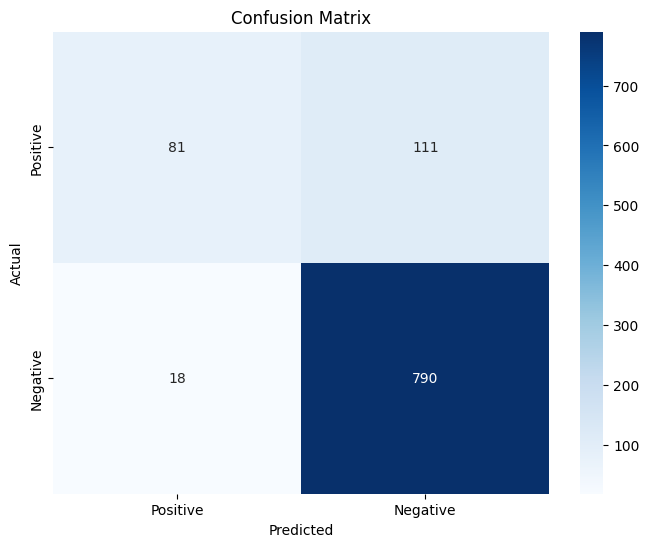

In [35]:
x_train = features_bow
y_train = list(dataset_subset_train[:]['polarity'])

# para ficar com o dataset de teste
test_list = remove_punctuation([entry['review_text_processed'] for entry in dataset_subset_test])
x_test = vectorizer.transform(test_list).toarray()
y_test = list(dataset_subset_test[:]['polarity'])

y_test_predict_nb = classify_NaiveBayesian(x_train, y_train, x_test)
y_test_predict_lr = classify_Logistic(x_train, y_train, x_test)

target_names=['Positive', 'Negative']

metrics_bow_nb = collect_classification_metrics(
    y_test, y_test_predict_nb, model_name="BOW + Naive Bayesian", target_names=target_names
)
report = evaluation(y_test_predict_nb, y_test, target_names=target_names)

              precision    recall  f1-score   support

    Positive      0.719     0.427     0.536       192
    Negative      0.876     0.960     0.916       808

    accuracy                          0.858      1000
   macro avg      0.798     0.694     0.726      1000
weighted avg      0.846     0.858     0.843      1000



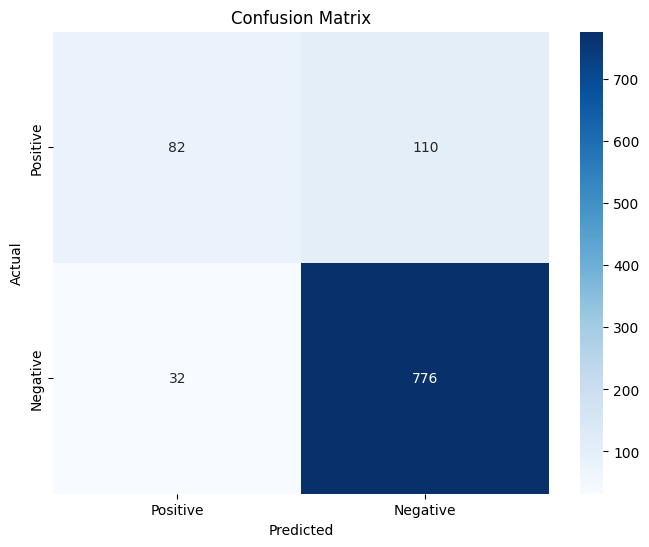

In [36]:
metrics_bow_lr = collect_classification_metrics(
    y_test, y_test_predict_lr, model_name="BOW + LR", target_names=target_names
)
report = evaluation(y_test_predict_lr, y_test, target_names=['Positive', 'Negative'])

              precision    recall  f1-score   support

    Positive      1.000     0.026     0.051       192
    Negative      0.812     1.000     0.896       808

    accuracy                          0.813      1000
   macro avg      0.906     0.513     0.474      1000
weighted avg      0.848     0.813     0.734      1000



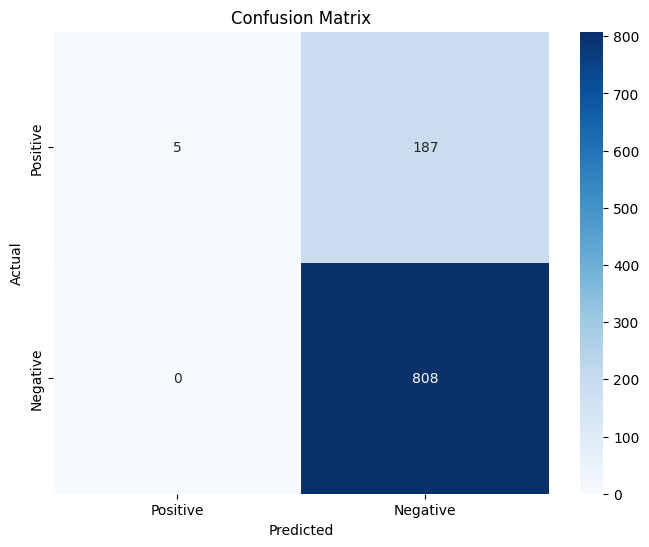

In [37]:
x_train_tfidf = features_tfidf
data_count_test = vectorizer_tfidf.transform(test_list)
x_test_tfidf = transformer_tf_idf.transform(data_count_test).toarray()

y_test_predict_nb_tfidf = classify_NaiveBayesian(x_train_tfidf, y_train, x_test_tfidf)
metrics_tfidf_nb = collect_classification_metrics(
    y_test, y_test_predict_nb_tfidf, model_name="TF-IDF + NB", target_names=target_names
)
report = evaluation(y_test_predict_nb_tfidf, y_test, target_names=['Positive', 'Negative'])

              precision    recall  f1-score   support

    Positive      0.853     0.302     0.446       192
    Negative      0.856     0.988     0.917       808

    accuracy                          0.856      1000
   macro avg      0.855     0.645     0.682      1000
weighted avg      0.856     0.856     0.827      1000



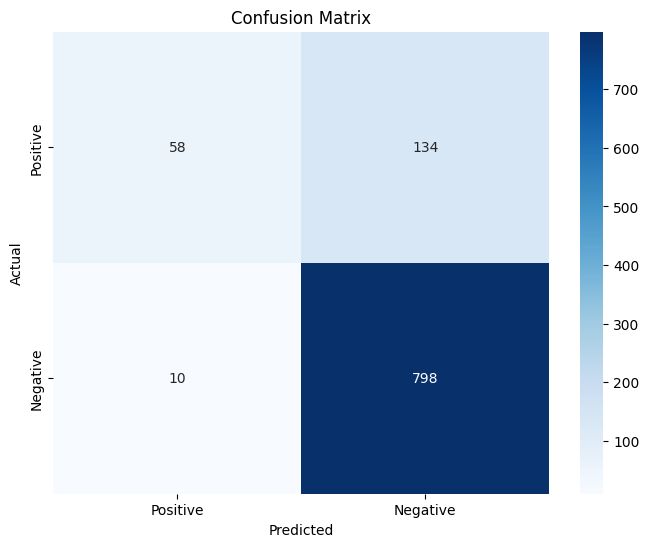

In [38]:
y_test_predict_lr_tfidf = classify_Logistic(x_train_tfidf, y_train, x_test_tfidf)

metrics_tfidf_lr = collect_classification_metrics(
    y_test, y_test_predict_lr_tfidf, model_name="TF-IDF + LR", target_names=target_names
)

report = evaluation(y_test_predict_lr_tfidf, y_test, target_names=['Positive', 'Negative'])

              precision    recall  f1-score   support

    Positive      0.755     0.417     0.537       192
    Negative      0.875     0.968     0.919       808

    accuracy                          0.862      1000
   macro avg      0.815     0.692     0.728      1000
weighted avg      0.852     0.862     0.846      1000



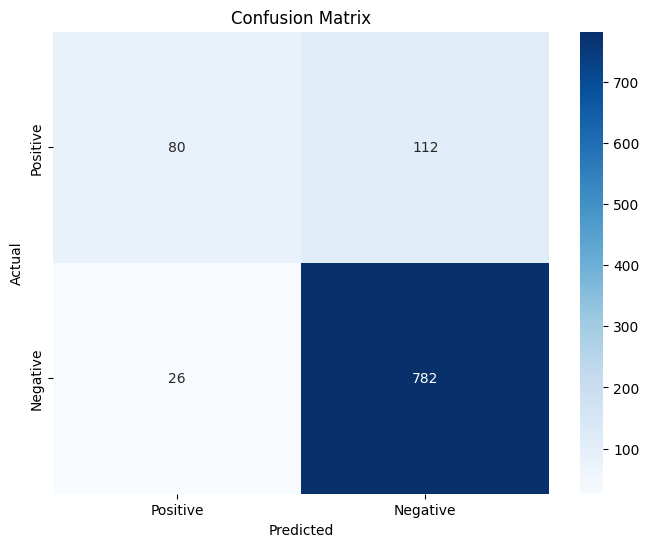

In [39]:
x_train_pmi = x_train_pmi_filtered
x_test_not_filtered_pmi = vectorizer_pmi.transform(test_list).toarray()
x_test_pmi = x_test_not_filtered_pmi[:, top_indices_pmi]

y_test_predict_nb_pmi = classify_NaiveBayesian(x_train_pmi, y_train, x_test_pmi)

metrics_pmi_nb = collect_classification_metrics(
    y_test, y_test_predict_nb_pmi, model_name="PMI + NB", target_names=target_names
)

report = evaluation(y_test_predict_nb_pmi, y_test, target_names=['Positive', 'Negative'])

              precision    recall  f1-score   support

    Positive      0.808     0.307     0.445       192
    Negative      0.857     0.983     0.915       808

    accuracy                          0.853      1000
   macro avg      0.832     0.645     0.680      1000
weighted avg      0.847     0.853     0.825      1000



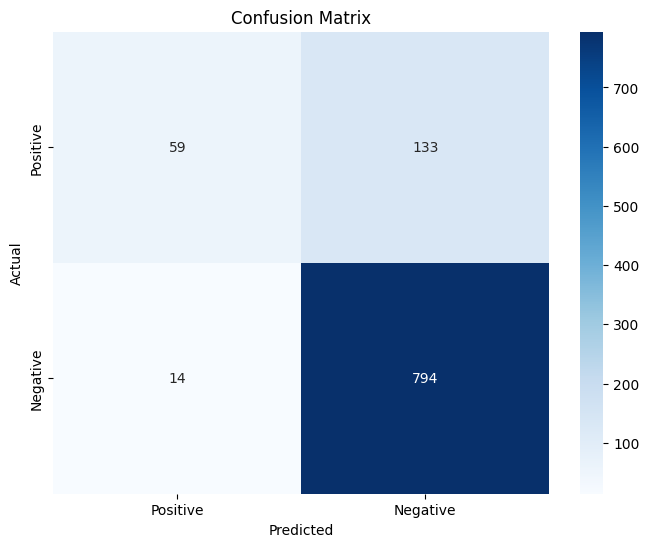

In [40]:
y_test_predict_lr_pmi = classify_Logistic(x_train_pmi, y_train, x_test_pmi)

metrics_pmi_lr = collect_classification_metrics(
    y_test, y_test_predict_lr_pmi, model_name="PMI + LR", target_names=target_names
)

report = evaluation(y_test_predict_lr_pmi, y_test, target_names=['Positive', 'Negative'])

In [41]:

import pandas as pd

def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

# Combine results into a DataFrame
comparison_df = pd.DataFrame([metrics_bow_lr, metrics_bow_nb, metrics_tfidf_lr, metrics_tfidf_nb, metrics_pmi_lr, metrics_pmi_nb])

styled_df = comparison_df.style.apply(highlight_max, subset=['Accuracy', 'Precision_Positive', 'Recall_Positive',
                                                             'F1_Positive', 'Precision_Negative',
                                                             'Recall_Negative', 'F1_Negative'])
styled_df


,Model,Accuracy,Precision_Positive,Recall_Positive,F1_Positive,Precision_Negative,Recall_Negative,F1_Negative
0,BOW + LR,0.858000,0.719298,0.427083,0.535948,0.875847,0.960396,0.916175
1,BOW + Naive Bayesian,0.871000,0.818182,0.421875,0.556701,0.876804,0.977723,0.924517
2,TF-IDF + LR,0.856000,0.852941,0.302083,0.446154,0.856223,0.987624,0.917241
3,TF-IDF + NB,0.813000,1.000000,0.026042,0.050761,0.812060,1.000000,0.896284
4,PMI + LR,0.853000,0.808219,0.307292,0.445283,0.856526,0.982673,0.915274
5,PMI + NB,0.862000,0.754717,0.416667,0.536913,0.874720,0.967822,0.918919


provavelmente explicar como regular o problema de classes unbalanced